In [17]:
import geopandas as gpd
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE



In [18]:
# Opening JSON file
filename = '../data/WirelessHotSpotsGEOJSON.geojson'
gdf = gpd.read_file(filename)
 
hotspot_df = pd.DataFrame(gdf)
hotspot_df.head()

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.74751 1.35019 0.00000)
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.83609 1.42804 0.00000)
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.85298 1.30020 0.00000)
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84648 1.28633 0.00000)
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.88965 1.39923 0.00000)


In [19]:
hotspot_df.size

5400

# Task 1: 
### From the table, what are some of the information you can deduce for each hotspot?

In [20]:

# Create an empty list to store hotspot information 
hotspot_info_list = []

# Function to extract attributes from the Description field
def extract_attributes(description):
    # Parse the HTML-like content
    soup = BeautifulSoup(description, 'html.parser')

    # Find all the rows in the table
    rows = soup.find_all('tr')

    # Initialize a dictionary to store hotspot information
    hotspot_info = {}

    # Iterate through the rows 
    for row in rows:
        th = row.find('th')
        td = row.find('td')
        if th and td:
            key = th.get_text()
            value = td.get_text()
            hotspot_info[key] = value

    return hotspot_info

# Iterate through each row in hotspot_df 
for index, row in hotspot_df.iterrows():
    name = row["Name"]
    description = row["Description"]
    coordinates = row["geometry"]

    attributes = extract_attributes(description)

    # Create a dictionary with hotspot information
    hotspot_info = {
        "Name": name,
        "Coordinates": coordinates,
        **attributes  
    }

    # Append the hotspot information dictionary to the list
    hotspot_info_list.append(hotspot_info)


hotspot_info_df = pd.DataFrame(hotspot_info_list)
hotspot_info_df.head()


,Name,Coordinates,Y,X,LOCATION_NAME,LOCATION_TYPE,POSTAL_CODE,STREET_ADDRESS,OPERATOR_NAME,INC_CRC,FMEL_UPD_D
0,kml_1,POINT Z (103.747514398535 1.35019080604781 0),36922.92412,18450.95232,Bukit Batok CC,Community,659959,21 Bukit Batok Central,M1,9BB55356462956EF,20200318162531
1,kml_2,POINT Z (103.836092102185 1.42803584532257 0),45530.46595,28308.65184,1 Northpoint Drive,Community,768019,1 Northpoint Drive,M1,BD725D1716D3959C,20200318162531
2,kml_3,POINT Z (103.852975339767 1.3001965525977 0),31394.65632,30187.62071,155 Waterloo St,Government,187962,155 Waterloo Street,M1,05EF8371C69FD210,20200318162531
3,kml_4,POINT Z (103.846479315186 1.28632940482837 0),29861.29437,29464.67939,20 Upper Pickering St,Community,058284,20 Upper Pickering Street,M1,AD6A8E558E96E20B,20200318162531
4,kml_5,POINT Z (103.88965392915 1.3992285612873 0),42345.17715,34269.36498,7 Star Canteen,F&B,540338,338 Anchorvale Crescent,M1,67FF233DF9721356,20200318162531


In [22]:
hotspot_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            1800 non-null   object
 1   Coordinates     1800 non-null   object
 2   Y               1800 non-null   object
 3   X               1800 non-null   object
 4   LOCATION_NAME   1800 non-null   object
 5   LOCATION_TYPE   1800 non-null   object
 6   POSTAL_CODE     1800 non-null   object
 7   STREET_ADDRESS  1800 non-null   object
 8   OPERATOR_NAME   1800 non-null   object
 9   INC_CRC         1800 non-null   object
 10  FMEL_UPD_D      1800 non-null   object
dtypes: object(11)
memory usage: 154.8+ KB


In [21]:
hotspot_info_df.columns

Index(['Name', 'Coordinates', 'Y', 'X', 'LOCATION_NAME', 'LOCATION_TYPE',
       'POSTAL_CODE', 'STREET_ADDRESS', 'OPERATOR_NAME', 'INC_CRC',
       'FMEL_UPD_D'],
      dtype='object')

These are the available information for each hotspot as shown in the table above

In [23]:
hotspot_info_df.head()

,Name,Coordinates,Y,X,LOCATION_NAME,LOCATION_TYPE,POSTAL_CODE,STREET_ADDRESS,OPERATOR_NAME,INC_CRC,FMEL_UPD_D
0,kml_1,POINT Z (103.747514398535 1.35019080604781 0),36922.92412,18450.95232,Bukit Batok CC,Community,659959,21 Bukit Batok Central,M1,9BB55356462956EF,20200318162531
1,kml_2,POINT Z (103.836092102185 1.42803584532257 0),45530.46595,28308.65184,1 Northpoint Drive,Community,768019,1 Northpoint Drive,M1,BD725D1716D3959C,20200318162531
2,kml_3,POINT Z (103.852975339767 1.3001965525977 0),31394.65632,30187.62071,155 Waterloo St,Government,187962,155 Waterloo Street,M1,05EF8371C69FD210,20200318162531
3,kml_4,POINT Z (103.846479315186 1.28632940482837 0),29861.29437,29464.67939,20 Upper Pickering St,Community,058284,20 Upper Pickering Street,M1,AD6A8E558E96E20B,20200318162531
4,kml_5,POINT Z (103.88965392915 1.3992285612873 0),42345.17715,34269.36498,7 Star Canteen,F&B,540338,338 Anchorvale Crescent,M1,67FF233DF9721356,20200318162531


# Task 2: 
### Due to a system error, the location type column for the last 200 rows of the dataset has become garbled. Using all earlier rows as well as all other columns in the dataset, build a classification model to predict the location type for these hotspots. You may treat the three rarest location types as one category. (Note: you may wish to create some additional features based on available ones.)

/Users/yings/Desktop/govtech/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yings/Desktop/govtech/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yings/Desktop/govtech/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


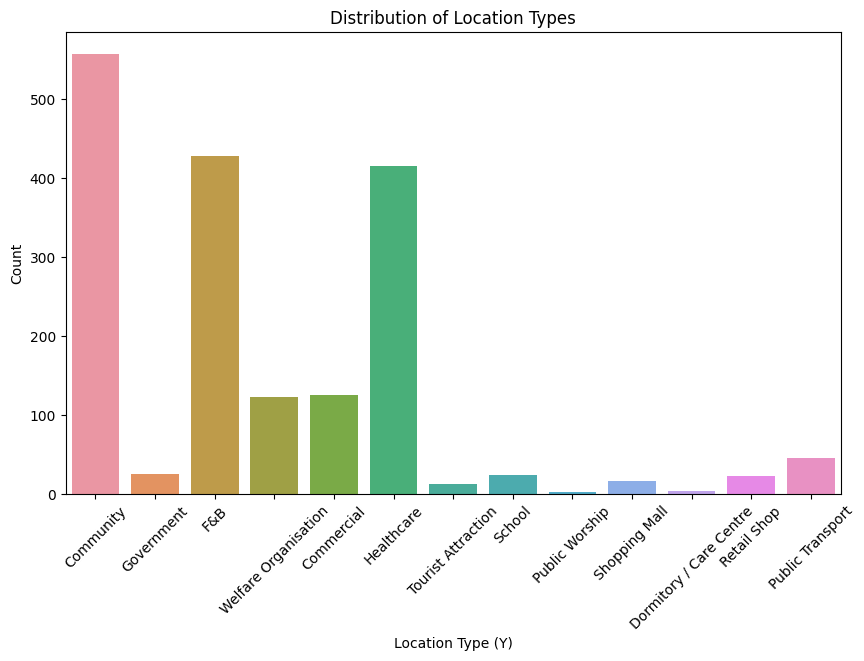

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=hotspot_info_df, x='LOCATION_TYPE')
plt.xticks(rotation=45)
plt.xlabel('Location Type (Y)')
plt.ylabel('Count')
plt.title('Distribution of Location Types')
plt.show()


The graph above shows an imbalanced dataset.

In [25]:
def haversine_dist(lat1, lng1, lat2 = 1.287953, lng2 = 103.851784): # coordinates of downtown in sg
        """
        Calculate  distance between two points 
        on the earth's surface given their latitude and longitude 
        in decimal degrees.
        
        Parameters:
        - lat1, lng1: Latitude and Longitude of the first point.
        - lat2, lng2: Latitude and Longitude of the second point.
        
        Returns:
        - h: Distance in kilometers between the two points.
        """

        # Convert decimal degrees to radians
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))

        # Radius of the Earth in kilometers. Use 6371 for kilometers or 3959 for miles
        radius = 6371

        # Differences in coordinates
        dlat = lat2 - lat1
        dlng = lng2 - lng1

        # Haversine formula
        a = np.sin(dlat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2) ** 2
        h = 2 * radius * np.arcsin(np.sqrt(a))

        return h


In [26]:


def bearing_degree(lat1, lng1, lat2, lng2):
    '''
    Calculate the initial bearing between two points on the earth's surface. (from city centre)
    '''
    # Convert degrees to radians
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])
    
    # Difference in longitudes
    diff_lng = lng2 - lng1

    # Calculate bearing
    y = np.sin(diff_lng) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(diff_lng)
    bearing = np.degrees(np.arctan2(y, x))

    # Normalize bearing to 0-360 degrees
    return (bearing + 360) % 360


In [27]:
def cartesian_to_polar(row):
    r = np.sqrt(row['Latitude']**2 + row['Longitude']**2)
    theta = np.degrees(np.arctan2(row['Latitude'], row['Longitude']))
    return pd.Series([r, theta], index=['r', 'theta'])


In [28]:
hotspot_info_df.columns

Index(['Name', 'Coordinates', 'Y', 'X', 'LOCATION_NAME', 'LOCATION_TYPE',
       'POSTAL_CODE', 'STREET_ADDRESS', 'OPERATOR_NAME', 'INC_CRC',
       'FMEL_UPD_D'],
      dtype='object')

In [29]:
hotspot_info_df['LOCATION_TYPE'].value_counts()

LOCATION_TYPE
Community                  557
F&B                        428
Healthcare                 415
Commercial                 125
Welfare Organisation       123
Public Transport            46
Government                  25
School                      24
Retail Shop                 23
Shopping Mall               16
Tourist Attraction          12
Dormitory / Care Centre      4
Public Worship               2
Name: count, dtype: int64

In [30]:

rare_location_types = hotspot_info_df['LOCATION_TYPE'].value_counts().tail(3).index.tolist()
hotspot_info_df['LOCATION_TYPE']= hotspot_info_df['LOCATION_TYPE'].apply(lambda x: 'Others' if x in rare_location_types else x)


training_df = hotspot_info_df.iloc[:-200]
missing_data = hotspot_info_df.iloc[-200:]



# Feature Engineering Steps
def feature_engin(data):
    
    # create numerical features using Latitude and Longitude from Coordinates
    data['Latitude'] = data['Coordinates'].apply(lambda point: point.y)
    data['Longitude'] = data['Coordinates'].apply(lambda point: point.x)
    city_lat, city_lng = 1.287953, 103.851784
    data['Distance from city centre'] = data.apply(lambda row: haversine_dist(row['Latitude'], row['Longitude'], city_lat, city_lng), axis = 1)
    data['Bearing from city centre'] = data.apply(lambda row: bearing_degree(row['Latitude'], row['Longitude'], city_lat, city_lng), axis = 1)
    data[['r', 'theta']] = data.apply(cartesian_to_polar, axis=1)
        
    # encode categorical variables
    encoder = LabelEncoder()
    data['OPERATOR_NAME'] = encoder.fit_transform(data['OPERATOR_NAME'])

    # handle missing values 
    # For simplicity, fill missing values with the mean of the respective columns.
    imputer = SimpleImputer(strategy='mean')
    data[['Y', 'X']] = imputer.fit_transform(data[['Y', 'X']])

    # Define features and target variable
    idv = ['OPERATOR_NAME', 'theta', 'r', 'Bearing from city centre', 'Distance from city centre', 'Longitude', 'Latitude' ]
    dv = 'LOCATION_TYPE'
    return data[idv], data[dv]

X, y = feature_engin(training_df)
X_test, y_test = feature_engin(missing_data)


sampling_stat = {
    'Community': 557, 
    'F&B': 557, 
    'Healthcare': 557, 
    'Commercial': 557, 
    'Welfare Organisation': 557, 
    'Public Transport': 557, 
    'Government': 557, 
    'School': 557, 
    'Retail Shop': 557, 
    'Shopping Mall': 557, 
    'Others': 557

}

smote_only = SMOTE(random_state=1, sampling_strategy=sampling_stat)
X_res_smote, y_res_smote = smote_only.fit_resample(X, y)
    
# Classifiers
rf = RandomForestClassifier(n_estimators=100)
xg = XGBClassifier()
knn = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('xg', xg),
    ('knn', knn)
], voting='hard')

voting_clf.fit(X_res_smote, y_res_smote)

y_pred = voting_clf.predict(X_test)


/var/folders/s6/41_4v1b11gvf7352q3dxgbl80000gn/T/ipykernel_3630/1663330040.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Latitude'] = data['Coordinates'].apply(lambda point: point.y)
/var/folders/s6/41_4v1b11gvf7352q3dxgbl80000gn/T/ipykernel_3630/1663330040.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Longitude'] = data['Coordinates'].apply(lambda point: point.x)
/var/folders/s6/41_4v1b11gvf7352q3dxgbl80000gn/T/ipykernel_3630/1663330040.py:17: SettingWithCopyWarning: 
A value is t

# Task 3: 
### The information has now been recovered from a backup copy of the file. Compared to the true location types, how good was your model? Be prepared to explain the metrics you use to evaluate your model.

In [31]:
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, 
                             f1_score)

def evaluate_multiclass_results(y_test, y_pred):
    '''
    Evaluate multiclass classification results.
    '''
    # Create confusion matrix of validation data
    cm = confusion_matrix(y_test, y_pred)
    
    print("Confusion Matrix: \n", cm)
    print("\n")
    
    # Evaluation Statistics
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Recall (macro): ", recall_score(y_test, y_pred, average='macro'))
    print("Precision (macro): ", precision_score(y_test, y_pred, average='macro'))
    print("F1 (macro): ", f1_score(y_test, y_pred, average='macro'))
    
    print("\n")
    
    print("Recall (micro): ", recall_score(y_test, y_pred, average='micro'))
    print("Precision (micro): ", precision_score(y_test, y_pred, average='micro'))
    print("F1 (micro): ", f1_score(y_test, y_pred, average='micro'))
    
    print("\n")
    
    print("Recall (weighted): ", recall_score(y_test, y_pred, average='weighted'))
    print("Precision (weighted): ", precision_score(y_test, y_pred, average='weighted'))
    print("F1 (weighted): ", f1_score(y_test, y_pred, average='weighted'))

    


In [32]:
evaluate_multiclass_results(y_test, y_pred)

Confusion Matrix: 
 [[ 4  1  1  1  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  1]
 [ 5 35 27 11  3  1  1  2  1  6 13]
 [ 0  0  0  0  0  1  0  0  0  0  0]
 [ 1  0 50  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 3  4  4  0  0  0  2  3  0  0  0]
 [ 1  1  0  0  0  0  0  1  0  0  0]
 [ 5  1  0  0  0  0  0  0  2  0  0]
 [ 1  0  2  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0  0  0]]


Accuracy:  0.195
Recall (macro):  0.20315517815517817
Precision (macro):  0.2207288835195812
F1 (macro):  0.14726710620952496


Recall (micro):  0.195
Precision (micro):  0.195
F1 (micro):  0.195


Recall (weighted):  0.195
Precision (weighted):  0.3269587486157253
F1 (weighted):  0.2091218982670888


/Users/yings/Desktop/govtech/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yings/Desktop/govtech/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As the data is imbalanced, we may want to look at F1 score instead of accuracy or AUC. From the results above, the model is performing poorly at 0.21. Areas to improve could be to use stratified cross validation to increase the robustness of the model, introduce other more meaningful and relevant features, etc.